# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

### Table of Content 
I. [Load and Clean Data ](#load)<br>
II. [Exploratory Data Analysis](#EDA)<br>
III.[Feature Engineering](#features)<br>
IV. [Modelling](#models)<br>
V. [Reports](#reports)<br>


In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, when, asc, count,lit
from pyspark.sql.functions import min as fmin, max as fmax, sum as fsum, round as fround
from pyspark.sql.types import IntegerType, FloatType, StringType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [2]:
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [3]:
#set seaborn style
sns.set(style='whitegrid')

In [4]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

# Load and Clean Dataset
<a class="anchor" id="load"></a>
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, rec
ords without userids or sessionids. 

In [5]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [8]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [9]:
#count the number of sessions in the df
df.count()

286500

In [10]:
#count the empties in userId
df.filter(df['userId']=='').count()

8346

In [11]:
#clean the df with userIds
df = df.filter(df['userId']!='')

In [12]:
# Create a user defined function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the udf on the ts column
df = df.withColumn("time", get_time(df.ts))

In [13]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57')]

# Exploratory Data Analysis
<a class="anchor" id="EDA"></a>
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
# Number of unique userId's to be sampled for exploratory data analysis
user_sample_size = 250

# Unique userId's from the full dataset
users = [row.userId for row in df.select('userId').dropDuplicates().collect()]

# Sample userId's
if len(users) > user_sample_size:
    user_sample = list(np.random.choice(users, size=user_sample_size, replace=False))
else:
    user_sample = list(np.copy(users))

# Create subset of the full dataset
df_sub = df.filter(df['userId'].isin(user_sample))

In [15]:
# Possible values of level
coln = 'level'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'level':
['free', 'paid']


In [16]:
# Possible values of page
coln = 'page'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'page':
['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'Cancellation Confirmation', 'About', 'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']


In [17]:
#first we should define a column named Churn as dataset's label for predict
#find the flag event
df.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [18]:
#define the churn
df = df.withColumn('churn', when(df.page == 'Cancellation Confirmation', 1).otherwise(0))
df = df.withColumn('Churn', fmax('churn').over(Window.partitionBy('UserId')))

In [19]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_sub = df_sub.withColumn("churned", flag_churn_event("page"))

# Calculate flags of churn
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# # 1 means the user has already churned at this timestamp
# df_sub = df_sub.withColumn("churnPhase", fsum('churned').over(windowval))

# 1 means the user is a churn user
df_sub = df_sub.withColumn("churnUser", fmax('churned').over(Window.partitionBy("userId")))

### Churn vs. Level (Paid/Free)

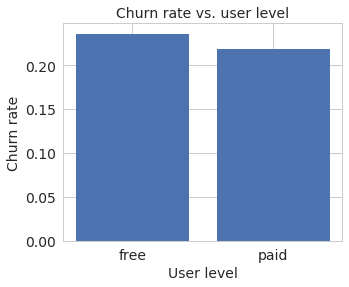

In [20]:
# Calculate churns by level
levels = df_sub.select(['userId', 'level', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('level')\
    .agg(count('userId').alias('num_users'), fsum('churnUser').alias('num_churns'))
levels_df = levels.toPandas()

# Visualize level patterns
plt.figure(figsize=(5,4))
plt.bar(levels_df['level'], levels_df['num_churns'] / levels_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User level", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.title("Churn rate vs. user level", fontsize=14);

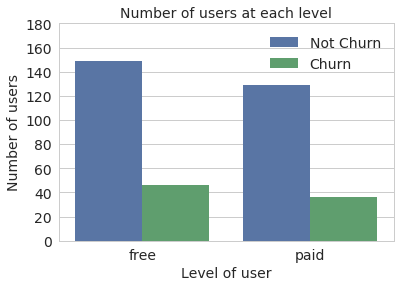

In [21]:
# Visualize the number of users by level
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
level_users_pd = df_sub.select(['userId', 'level', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(6, 4))
sns.countplot(x="level", hue="churnUser", data=level_users_pd,
#                palette=['steelblue', 'orange'], ci=None,
);
plt.ylim(0, 180)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Level of user", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of users at each level", fontsize=14)
plt.legend(loc='best', fontsize=14);

### Churn vs. page events

In [22]:
# Create pivot table of page events
pages = df_sub.groupBy(['userId']).pivot('page').count().fillna(0)
pages_df = pages.toPandas()

pages_df = pages_df.rename(columns={"Cancellation Confirmation": "Churn"})
pages_df.head()

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3,4,8,0,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2
1,100010,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2
2,125,0,0,0,1,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0
3,51,2,28,52,1,1,23,1,12,75,24,2111,0,1,12,0,0,21,100,0
4,124,7,74,118,0,0,41,6,23,176,59,4079,4,6,20,0,0,41,171,0


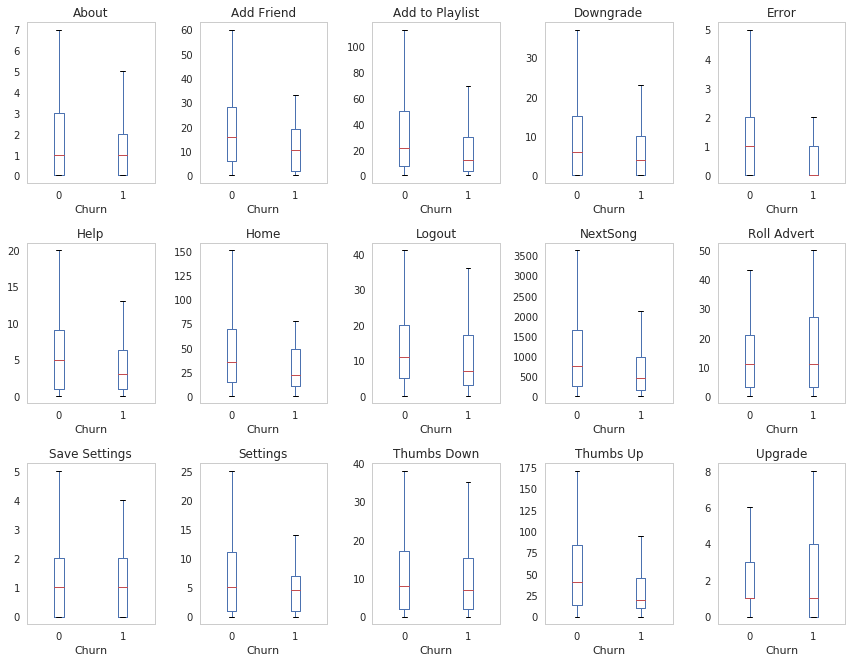

In [23]:
# Visualize churn patterns by page event
fig = plt.figure(figsize=(12, 12))
cols_interest = ['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 
                 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Thumbs Down', 
                 'Thumbs Up', 'Upgrade']

for i, coln in enumerate(cols_interest):
    ax = fig.add_subplot(4,5,i+1)
    pages_df.boxplot(coln, ax=ax, grid=False,  by='Churn', showfliers=False);

fig.suptitle('')
plt.tight_layout()

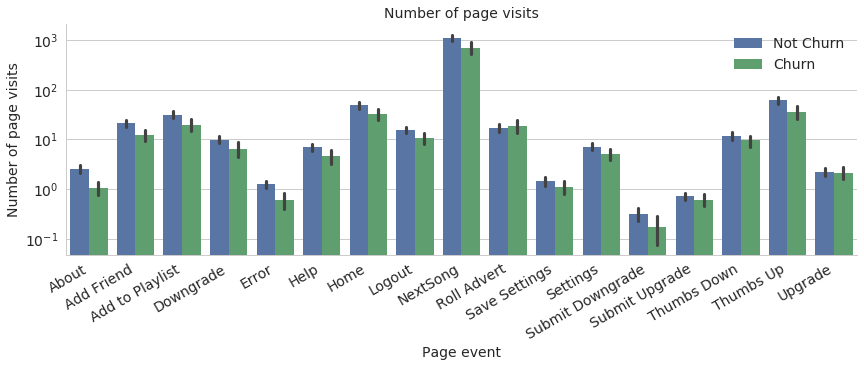

In [24]:
# Visualize the distribution of page events
pages_df['Churn'] = pages_df['Churn'].replace({1: "Churn", 0: "Not Churn"})
pages_df = pages_df.drop('Cancel', axis=1)

page_events_pd = pd.melt(
    pages_df, id_vars=['userId', 'Churn'], 
    value_vars=list(pages_df.columns[1:].drop('Churn')),
    var_name='page', 
    value_name='number_visits'
).reset_index()

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="number_visits", hue="Churn", data=page_events_pd,
               kind="bar", aspect=3, legend=False, log=True);
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits", fontsize=14)
plt.legend(loc='best', fontsize=14);

# Feature Engineering
<a class="anchor" id="features"></a>
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

>Extract 8 features that might have higher impact on churning: 
1. total songs played
2. number of thumbs up 
3. number of thumbs down 
4. time since registration 
5. average songs played per session 
6. friends added
7. errors
8. churn

In [26]:
features=[]

In [27]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [28]:
#1. total songs played
songs_played_df= df.select('userId','page').where(df.page =='NextSong').groupby('userId').count()\
                .withColumnRenamed('count','songs')
features.append(songs_played_df)

#2. thumbs up    
thumbs_up_df = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupby('userId').count()\
                                          .withColumnRenamed('count', 'thumbs_up')
features.append(thumbs_up_df)

#3. thumbs down    
thumbs_down_df = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupby('userId').count() .withColumnRenamed('count', 'thumbs_down')
features.append(thumbs_down_df)

# 4. time since registration 
time_since_registration_df = df.groupby(['userId', 'ts', 'registration']).count() \
                    .withColumn('life_time', (df.ts - df.registration) / 1000) \
                    .groupBy('userId').agg(fmax('life_time')) \
                    .withColumnRenamed('max(life_time)', 'time_since_registration')
features.append(time_since_registration_df)


# 5. average songs played per session 
avg_songs_p_session_df = df.where(df.song.isNotNull()).groupby(['userId', 'sessionId']).count()\
                            .groupby(['userId']).agg({'count': 'avg'}) \
                            .withColumnRenamed('avg(count)', 'avg_songs_p_session')
features.append(avg_songs_p_session_df )

# 6. friends added
number_of_friends_df = df.where('page == "Add Friend"').groupby(['userId']).count()\
                        .groupby(['userId']).agg({'count': 'avg'}).withColumnRenamed('avg(count)', 'friends_added')
features.append(number_of_friends_df)

# 7. errors
errors_df = df.groupby('userId').agg(fsum(when(col('page') == 'Error', 1).otherwise(0)).alias('errors'))
features.append(errors_df)

# 8. churn
churn = df.select('userId', 'Churn').dropDuplicates()
features.append(churn)

In [29]:
print(features)

[DataFrame[userId: string, songs: bigint], DataFrame[userId: string, thumbs_up: bigint], DataFrame[userId: string, thumbs_down: bigint], DataFrame[userId: string, time_since_registration: double], DataFrame[userId: string, avg_songs_p_session: double], DataFrame[userId: string, friends_added: double], DataFrame[userId: string, errors: bigint], DataFrame[userId: string, Churn: int]]


In [30]:
test_final_df = songs_played_df.join(thumbs_up_df,on='userId',how='inner').\
                        join(thumbs_down_df,on='userId',how='inner').\
                        join(errors_df,on='userId',how='inner').\
                        join(time_since_registration_df,on='userId',how='inner').\
                        join(avg_songs_p_session_df,on='userId',how='inner').\
                        join(number_of_friends_df,on='userId',how='inner').\
                        join(churn,on='userId',how='inner')

    

In [31]:
test_final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- songs: long (nullable = false)
 |-- thumbs_up: long (nullable = false)
 |-- thumbs_down: long (nullable = false)
 |-- errors: long (nullable = true)
 |-- time_since_registration: double (nullable = true)
 |-- avg_songs_p_session: double (nullable = true)
 |-- friends_added: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [32]:
test_final_df.show(5)

+------+-----+---------+-----------+------+-----------------------+-------------------+-------------+-----+
|userId|songs|thumbs_up|thumbs_down|errors|time_since_registration|avg_songs_p_session|friends_added|Churn|
+------+-----+---------+-----------+------+-----------------------+-------------------+-------------+-----+
|100010|  275|       17|          5|     0|              4807612.0| 39.285714285714285|          4.0|    0|
|200002|  387|       21|          6|     0|              6054448.0|               64.5|          4.0|    0|
|   124| 4079|      171|         41|     6|            1.1366431E7| 145.67857142857142|         74.0|    0|
|    51| 2111|      100|         21|     1|              1680985.0|              211.1|         28.0|    1|
|     7|  150|        7|          1|     1|              6288035.0| 21.428571428571427|          1.0|    0|
+------+-----+---------+-----------+------+-----------------------+-------------------+-------------+-----+
only showing top 5 rows



In [33]:
test_final_df.columns

['userId',
 'songs',
 'thumbs_up',
 'thumbs_down',
 'errors',
 'time_since_registration',
 'avg_songs_p_session',
 'friends_added',
 'Churn']

In [34]:
# Create VectorAssembler and StandardScaler objects
# numeric features transform separately from binary
num_vector = VectorAssembler(inputCols=['songs','thumbs_up', 'thumbs_down','errors','time_since_registration',\
                                        'avg_songs_p_session','friends_added'], 
                             outputCol='num_vector_assem')

num_scaler = StandardScaler(inputCol='num_vector_assem', outputCol ='num_vector_sc', withStd=True, withMean=True)

final_vector = VectorAssembler(inputCols=['num_vector_sc'], 
                               outputCol='features_vector')

In [35]:
# Transform data
data = num_vector.transform(test_final_df)

feature_standardize = num_scaler.fit(data)
data = feature_standardize.transform(data)

data = final_vector.transform(data)

In [36]:
data.show(2)

+------+-----+---------+-----------+------+-----------------------+-------------------+-------------+-----+--------------------+--------------------+--------------------+
|userId|songs|thumbs_up|thumbs_down|errors|time_since_registration|avg_songs_p_session|friends_added|Churn|    num_vector_assem|       num_vector_sc|     features_vector|
+------+-----+---------+-----------+------+-----------------------+-------------------+-------------+-----+--------------------+--------------------+--------------------+
|100010|  275|       17|          5|     0|              4807612.0| 39.285714285714285|          4.0|    0|[275.0,17.0,5.0,0...|[-0.7981503730138...|[-0.7981503730138...|
|200002|  387|       21|          6|     0|              6054448.0|               64.5|          4.0|    0|[387.0,21.0,6.0,0...|[-0.6981363532632...|[-0.6981363532632...|
+------+-----+---------+-----------+------+-----------------------+-------------------+-------------+-----+--------------------+-----------------

In [37]:
#final data
data = data.select(data.Churn, data.features_vector)
data.take(1)

[Row(Churn=0, features_vector=DenseVector([-0.7982, -0.7053, -0.6084, -0.8536, -0.723, -0.944, -0.8644]))]

# Modelling
<a class="anchor" id="models"></a>
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [38]:
train, test = data.randomSplit([0.6, 0.4], seed=42)

In [39]:
#baseline model
baseline = test.withColumn('prediction', lit(0.0))
baseline.show(5)

+-----+--------------------+----------+
|Churn|     features_vector|prediction|
+-----+--------------------+----------+
|    0|[-0.7981503730138...|       0.0|
|    0|[-0.6981363532632...|       0.0|
|    0|[2.59875436923173...|       0.0|
|    0|[0.66544764815872...|       0.0|
|    0|[0.67794940062755...|       0.0|
+-----+--------------------+----------+
only showing top 5 rows



In [40]:
def evaluate_print(model_result, model_name, start, end):
    
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
    evaluator.setLabelCol('Churn')
    accuracy = evaluator.evaluate(model_result, {evaluator.metricName : 'accuracy'})
    f1 = evaluator.evaluate(model_result, {evaluator.metricName : 'f1'})
    time = (end - start)/60
    
    result = [model_name, round(accuracy,3), round(f1,3), round(time,1)]
    
    print('{} performance metrics:'.format(model_name))
    print('Accuracy: {}'.format(accuracy))
    print('F-1 Score: {}'.format(f1))
    print('Total training time: {} minutes'.format(time))
    
    return result

In [41]:
#print baseline model
baseline_result = evaluate_print(baseline, 'Baseline', 0, 0)

Baseline performance metrics:
Accuracy: 0.7567567567567568
F-1 Score: 0.651975051975052
Total training time: 0.0 minutes


### Logistic Regression model

In [42]:
numFolds = 3
lr = LogisticRegression(maxIter=10, labelCol='Churn', featuresCol='features_vector')
evaluator = MulticlassClassificationEvaluator(labelCol='Churn')

pipeline = Pipeline(stages=[lr])
lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.1, 0.01, 0.001])
                .build())


crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=lr_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

lr_start = time.time()
lr_model = crossval.fit(train)
lr_end = time.time()

In [43]:
lr_results = lr_model.transform(test)

lr_safe = evaluate_print(lr_results, 'Logistic Regression', lr_start, lr_end)


Logistic Regression performance metrics:
Accuracy: 0.7837837837837838
F-1 Score: 0.7401918047079337
Total training time: 7.29771386384964 minutes


### Random Forest Model

In [44]:
numFolds = 3
rf = RandomForestClassifier(labelCol='Churn', featuresCol='features_vector', seed = 42)
evaluator = MulticlassClassificationEvaluator(labelCol='Churn')

pipeline = Pipeline(stages=[rf])
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10,20])
             .addGrid(rf.maxDepth, [10,20])
             .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=rf_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

rf_start = time.time()
rf_model = crossval.fit(train)
rf_end = time.time()

In [45]:
rf_results = rf_model.transform(test)

rf_safe = evaluate_print(rf_results, 'Random Forest', rf_start, rf_end)


Random Forest performance metrics:
Accuracy: 0.7972972972972973
F-1 Score: 0.7787950222027301
Total training time: 10.96668842236201 minutes


### Support Vector Machine

In [46]:
numFolds = 3
svc = LinearSVC(labelCol='Churn', featuresCol='features_vector')
evaluator = MulticlassClassificationEvaluator(labelCol='Churn')

pipeline = Pipeline(stages=[svc])
svc_paramGrid = (ParamGridBuilder()
                 .addGrid(svc.maxIter, [5,10])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=svc_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

svc_start = time.time()
svc_model = crossval.fit(train)
svc_end = time.time()

In [47]:
svc_results = svc_model.transform(test)

svc_safe = evaluate_print(svc_results, "Support Vector Machine", svc_start, svc_end)


Support Vector Machine performance metrics:
Accuracy: 0.7837837837837838
F-1 Score: 0.7108108108108109
Total training time: 8.25154017607371 minutes


### Reports
<a class="anchor" id="reports"></a>

In [48]:
def reports(model_result):
    '''
    INPUT:
    model_result : list
    
    OUTPUT: None
    
    Description:
    The function aggregate and prints results of models
    
    '''
    print(model_result[0])
    print('Accuracy: {}'.format(model_result[1]))
    print('F-1 Score: {}'.format(model_result[2]))
    print('Total training time: {} minutes'.format(model_result[3]))
    
    print()

In [49]:
results_models_list = [baseline_result, lr_safe, rf_safe, svc_safe]

for res in results_models_list:
    reports(res)

Baseline
Accuracy: 0.757
F-1 Score: 0.652
Total training time: 0.0 minutes

Logistic Regression
Accuracy: 0.784
F-1 Score: 0.74
Total training time: 7.3 minutes

Random Forest
Accuracy: 0.797
F-1 Score: 0.779
Total training time: 11.0 minutes

Support Vector Machine
Accuracy: 0.784
F-1 Score: 0.711
Total training time: 8.3 minutes



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.